# Grid search

A typical use case of `pythonradex` is to compute a grid of models to infer the physical conditions corresponding to some observed flux. Here we provide an example of such a use case.

## Comment about performance

`pythonradex` provides a convenience function to calculate a grid of models. That function allows to compute a grid over the following parameters: external background radiation, column density, kinetic temperature and collider densities. The function is written in a way to calculate the grid as fast as possible.

Of course, the user can run a custom grid over other parameters (e.g. dust radiation field parameters), preferably by using the `update_parameters` function (initialising a new Cloud object is very inefficient; using the `update_parameters` method should be much faster). To optimise performance, in the loop over the parameters, it is recommended to put collider density and kinetic temperature in the outermost loop because updating them is more expensive compared to e.g. the column density.

## Scenario

Assume we measured the CO 3-2 flux from a source as $(2.8\pm0.4)\times 10^{-24}$ W/m$^2$. Further assume, for simplicity, that we know the kinetic temperature of the gas. We want to estimate the CO column density and the hydrogen density compatible with the observed flux. For simplicity, we assume a thermal ortho/para ratio of H$_2$ of 3. We assume that the source has a known solid angle of (10x10 au$^2$)/(100 pc)$^2$.

## Setup

In [1]:
from pythonradex import radiative_transfer,helpers
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt

In [2]:
datafilepath = './co.dat'
geometry = 'uniform slab'
line_profile_type = 'Gaussian'
width_v = 1*constants.kilo

#initialise the cloud
cloud = radiative_transfer.Cloud(
               datafilepath=datafilepath,geometry=geometry,
               line_profile_type=line_profile_type,width_v=width_v,
               warn_negative_tau=False)

## Define and run the model grid

We use the `model_grid` function to iterate over the grid of models. Here we comment on all the options before setting up the grid for our specific example. The input parameters defining the grid are:

* `ext_backgrounds`: a dictionary of the different external backgrounds. Entries can be functions of frequency, or a single number (constant background). Units are W/m$^2$/Hz/sr. Example: `ext_backgrounds = {'CMB':helpers.generate_CMB_background(),'zero':0}`
* `N_values`: list of column densities in m$^{-2}$. Example: `N_values = np.logspace(12,15,20)/constants.centi**2` (i.e. 20 column densities equally space in log space between 10$^{12}$ and 10$^{15}$ cm$^{-2}$)
* `Tkin_values`: list of kinetic temperatures in K. Example: `Tkin_values = np.linspace(20,100,30)`
* `collider_densities_values`: A dictionary with one entry for each collider. Each entry is a list of densities for which models should be computed for, using a "zip" logic (i.e. calculate a model for the first entries of each list, for the second entries of each list, etc). Example: `collider_densities_values = {'para-H2':np.array([1e3,1e4])/constants.centi**3,'ortho-H2':np.array([2e3,4e4])/constants.centi**3}`

The ouput will then be models covering all possible combinations of the above input parameters.

Two other (fixed) input parameters define the dust continuum radiation field. These are not part of the model grid.

* `T_dust`: The source function of the continuum radiation field is a black body at temperature `T_dust`. This parameter can be a function (taking a frequency array as input) or a single number (i.e. temperature independent of frequency). Defaults to 0. Examples: `T_dust = 0` (i.e. no dust), `T_dust = 100` (dust temperature of 100 K for all frequencies), `def T_dust(nu): return 100*nu/(200*constants.giga)` (dust temperature proportional to frequency).
* `tau_dust`: The optical depth of the dust. Same as `T_dust`, this can be a function of frequency, or a number (constant value for all frequencies). Defaults to 0.

Finally, the following input parameters define the output requested from the model grid:

* `requested_output`: A list of requested outputs. Possible entries are
    * 'level_pop' (fractional level population)
    * 'Tex' (excitation temperature for requested transitions)
    * 'tau_nu0_individual_transitions' (optical depth at the rest frequency of individual transitions, i.e. not including optical depth of dust or overlapping lines)
    * 'fluxes_of_individual_transitions' (fluxes in W/m$^{2}$ for requested transitions; only possible if dust and overlapping lines are optically thin)
    * 'tau_nu' (optical depth as function of frequency)
    * 'spectrum' (flux in W/m$^2$/Hz as function of frequency).
* `solid_angle`: Solid angle of the source. Necessary if 'fluxes_of_individual_transitions' or 'spectrum' are requested. Defaults to None.
* `transitions`: The indices of the transitions for which to calculate Tex, tau_nu and fluxes. Defaults to None. If None, then values for all transitions are calculated. The indices are relative to the list of transitions in the LAMDA file, starting with 0.
* `nu`: Array of frequencies in Hz. Needed if 'tau_nu' or 'spectrum' is requested. Defaults to None.

Each output model of the grid is given as a dictionary with the fields 'ext_background','N','Tkin' and 'collider_densities' (to identify the input parameters of the model) as well as any requested output fields.

Now, let's define the grid for our specific example:

In [3]:
#grid parameters:
#only a single background:
ext_backgrounds = {'CMB':helpers.generate_CMB_background(z=0)}
#explore column densities between 1e12 and 1e17 cm-2:
N_values = np.logspace(12,17,60)/constants.centi**2
#assume the kinetic temperature is known, so put only one value here:
Tkin_values = [50,]
#explore H2 densities between 100 and 1e6 cm-3
H2_densities = np.logspace(1,6,50)/constants.centi**3
#assume thermal ortho/para = 3:
collider_densities_values = {'para-H2':H2_densities/4,'ortho-H2':3*H2_densities/4}

#output parameters:
#we are only interested in the flux of CO 3-2:
requested_output = ['fluxes_of_individual_transitions',]
solid_angle = (10*constants.au)**2/(100*constants.parsec)**2
transitions = [2,] #we only need CO 3-2

#we leave dust parameters at their default (0, i.e. no dust).
#Also leave nu at default (None).
grid = cloud.model_grid(ext_backgrounds=ext_backgrounds,N_values=N_values,
                        Tkin_values=Tkin_values,
                        collider_densities_values=collider_densities_values,
                        requested_output=requested_output,solid_angle=solid_angle,
                        transitions=transitions)

Next, let's iterate over the grid and store the flux values:

In [4]:
#we will collect the model fluxes in a 2D array
output_CO32_flux = np.empty((N_values.size,H2_densities.size))

#now iterate over the grid and store the flux values
for model in grid:
    #determine the index for the column density dimension:
    i = np.where(model['N']==N_values)[0]
    #make sure the determination of the index is unique:
    assert len(i) == 1
    i = i[0]
    #determine the index for the H2 density dimension:
    model_H2 = model['collider_densities']['para-H2']\
                   +model['collider_densities']['ortho-H2']
    j = np.where(model_H2==H2_densities)[0]
    assert len(j) == 1
    j = j[0]
    #note: if we had requested several transitions,
    #model['fluxes_of_individual_transitions'] would be a list
    model_flux = model['fluxes_of_individual_transitions']
    output_CO32_flux[i,j] = model_flux

## Analysis

Now we can examine the CO 3-2 flux as a function of H$_2$ density and column density, and compare to the observed flux.

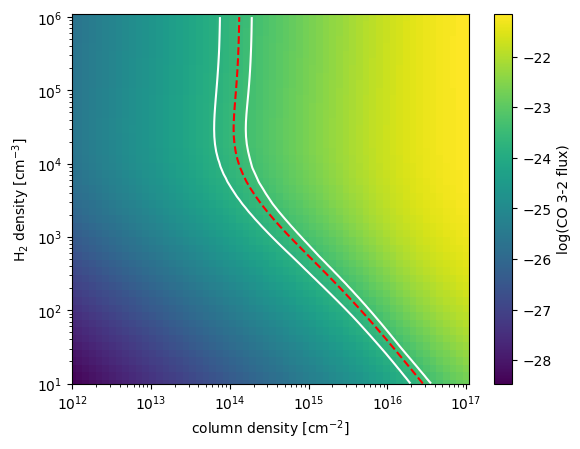

In [5]:
N_VALUES,H2_DENSITIES = np.meshgrid(N_values,H2_densities,indexing='ij')
fig,ax = plt.subplots()
#plot the log of the model flux for better visualisation
im = ax.pcolormesh(N_VALUES/constants.centi**-2,
                   H2_DENSITIES/constants.centi**-3,
                   np.log10(output_CO32_flux))
fig.colorbar(im,label='log(CO 3-2 flux)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'column density [cm$^{-2}$]')
ax.set_ylabel(r'H$_2$ density [cm$^{-3}$]')

measured_flux = 2.8e-24
measurement_error = 0.4e-24
sigma = np.abs((output_CO32_flux-measured_flux)/measurement_error)
#contour at the measured flux:
ax.contour(N_VALUES/constants.centi**-2,H2_DENSITIES/constants.centi**-3,
           np.log10(output_CO32_flux),levels=[np.log10(measured_flux),],
           colors='red')
#contours at +- 3 sigma:
ax.contour(N_VALUES/constants.centi**-2,H2_DENSITIES/constants.centi**-3,
           np.log10(sigma),levels=np.log10([3,]),colors='white')

We see that above a H$_2$ density of ${\sim}10^4$ cm$^{-3}$, the flux becomes independent of the H$_2$ density, which means the emission is in LTE. If LTE applies, the observed emission can be explained by a column density of ${\sim}10^{14}$ cm$^{-2}$. The measurement can also be explained by a higher column densitities of up to a few times $10^{16}$ cm$^{-2}$ if we consider H$_2$ densities as low as 10 cm$^{-3}$.